# Reinforcement Learning Agent for Statistical Arbitrage

## Install necessary libraries

In [1]:
%pip -q install -U numpy pandas pyarrow gdown gymnasium stable-baselines3 torch matplotlib tqdm tensorboard

Note: you may need to restart the kernel to use updated packages.


## Configuration

In [ ]:
CONFIG = {
    "DATA": {
        "drive_folder_id": "1uXEBUyySypdsW_ZqL-RZ3d1bWdIZisij",
        "structure": {"1d":"ohlcv_1d","1h":"ohlcv_1h","15m":"ohlcv_15m","5m":"ohlcv_5m","1m":"ohlcv_1m"},
        "file_pattern": "{TICKER}_{FREQ}.parquet",
        "tickers": ["BTC","ETH"],
        "sampling": "1h",
        "price_point": "close",
        "timezone_in": "CET",
        "timezone_out": "UTC",
        "forward_fill": True,
        "drop_na_after_ffill": True,
        "cache_dir": "./data_cache",
        "DOWNLOAD": {
            "method": "file_ids",
            "file_ids": {"BTC_1h": "1-sBNQpEFGEpVO3GDFCkSZiV3Iaqp2vB_", "ETH_1h": "1kj8G1scpFuEYTTXKEUzF9pwgGI2WFFL9"},
            "download_all": False
        }
    },
    "ENV": {
        "action_space": "continuous_weights",
        "include_cash": True,
        "shorting": False,
        "max_leverage": 1.0,
        "rebalance_interval": "1_bar",
        "episode_length": {"mode":"steps","value":2160},
        "lookback_window": 64,
        "features": {
            "log_return_window": 1,
            "vol_window": 64,
            "rsi_period": 14,
            "volume_change": True,
            "scaler": "rolling_zscore"
        },
        "transaction_costs": {
            "commission_bps": 5.0,
            "slippage_bps": 5.0,
            "apply_on_rebalance_only": True
        },
        "turnover_penalty": 0.0,
        "weight_smoothing": 0.0,
        "reward": {"type":"log_return_minus_risk","risk_lambda":0.001},
        "constraints": {"min_weight":0.0,"max_weight":1.0,"sum_to_one":True},
        "seed": 42
    },
    "SPLITS": {
        "data_start":"2024-09-02",
        "data_end":"2025-09-02",
        "train":["2024-09-02","2025-06-15"],
        "val":["2025-06-16","2025-07-15"],
        "test":["2025-07-16","2025-09-02"],
        "walk_forward": True,
        "wf_train_span_days": 180,
        "wf_test_span_days": 30,
        "wf_step_days": 30
    },
    "RL": {
        "algo":"PPO",
        "timesteps":1_000,
        "device":"auto",
        "policy":"MlpPolicy",
        "gamma":0.99,
        "gae_lambda":0.95,
        "clip_range":0.2,
        "n_steps":1024,
        "batch_size":256,
        "learning_rate":3e-4,
        "ent_coef":0.0,
        "vf_coef":0.5,
        "max_grad_norm":0.5
    },
    "EVAL": {
        "benchmarks":["equal_weight_hold","buy_and_hold_BTC","buy_and_hold_ETH"],
        "metrics":["CAGR","Sharpe","Sortino","MaxDrawdown","Calmar","Volatility","Turnover","HitRatio"],
        "plots":True,
        "reports_dir":"./reports"
    },
    "IO": {
        "models_dir":"./models",
        "tb_logdir":"./tb",
        "save_best_on_val": True
    }
}

## Imports

In [3]:
import os
import shutil
import json
import gdown # download files from google drive
import math
import glob
import random
import pytz

from datetime import timedelta

from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import torch

from tqdm import tqdm

## Check GPU availability

In [4]:
# run on cuda GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    CONFIG["RL"]["device"] = "cuda"
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

# run on Apple Silicon
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    CONFIG["RL"]["device"] = "mps"
    print("MPS is available. Using Apple Silicon GPU.")

# run on CPU (slow)
else:
    device = torch.device("cpu")
    CONFIG["RL"]["device"] = "cpu"
    print("CUDA and MPS are not available. Using CPU.")



MPS is available. Using Apple Silicon GPU.


## Set seeds for reproducibility

In [5]:
def set_all_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

set_all_seeds(CONFIG["ENV"]["seed"])

ANNUALIZATION = {"1m":365*24*60,"5m":365*24*12,"15m":365*24*4,"1h":365*24,"1d":365}

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

## Fetch Data from Google Drive

In [6]:
ROOT_ID = CONFIG["DATA"]["drive_folder_id"]
CACHE_DIR = CONFIG["DATA"]["cache_dir"]
ensure_dir(CACHE_DIR)

def download_drive_folder(root_id: str, out_dir: str):
    print("Mirroring Google Drive folder locally...")
    gdown.download_folder(id=root_id, output=out_dir, quiet=False, use_cookies=False)

def targeted_download_by_ids(file_id_map: Dict[str, str], out_dir: str):
    ensure_dir(out_dir)
    for name, fid in file_id_map.items():
        # check if file already exist in cache
        if os.path.exists(os.path.join(out_dir, name)) or os.path.exists(os.path.join(out_dir, f"{name}.parquet")):
            print(f"File {name} already exists in cache. Skipping download.")
            continue
        
        suffix = name if name.endswith(".parquet") else f"{name}.parquet"
        out_path = os.path.join(out_dir, suffix)
        print(f"Downloading {name} -> {out_path}")
        url = f"https://drive.google.com/uc?id={fid}"
        gdown.download(url, out_path, quiet=False, use_cookies=False)

download_method = CONFIG["DATA"]["DOWNLOAD"]["method"]
if download_method == "file_ids" and CONFIG["DATA"]["DOWNLOAD"]["file_ids"]:
    targeted_download_by_ids(CONFIG["DATA"]["DOWNLOAD"]["file_ids"], CACHE_DIR)
else:
    download_drive_folder(ROOT_ID, CACHE_DIR)

print("Download step complete.")


File BTC_1h already exists in cache. Skipping download.
File ETH_1h already exists in cache. Skipping download.
Download step complete.


## Load data

In [7]:
sampling = CONFIG["DATA"]["sampling"]
subfolder = CONFIG["DATA"]["structure"][sampling]
pattern_fmt = CONFIG["DATA"]["file_pattern"]
tickers = CONFIG["DATA"]["tickers"]

# Function to find parquet file path
def find_parquet_path(ticker: str, sampling: str) -> str:
    fname = pattern_fmt.format(TICKER=ticker, FREQ=sampling)
    # Try subfolder first
    candidates = glob.glob(os.path.join(CACHE_DIR, "**", subfolder, fname), recursive=True)
    # If not found, try flat cache
    if not candidates:
        candidates = glob.glob(os.path.join(CACHE_DIR, "**", fname), recursive=True)
    # If still not found, try direct file in cache (for file_ids downloads)
    if not candidates:
        direct_path = os.path.join(CACHE_DIR, fname)
        if os.path.exists(direct_path):
            candidates = [direct_path]
    if not candidates:
        raise FileNotFoundError(f"Could not find {fname} under {CACHE_DIR}.")
    return candidates[0]

def localize_and_align(df: pd.DataFrame, tz_in: str = None, tz_out: str = None) -> pd.DataFrame:
    if 'datetime' in df.columns:
        # Convert millisecond timestamps to datetime
        df['timestamp'] = pd.to_datetime(df['datetime'], unit='ms', utc=True)
        df = df.set_index('timestamp')
    # Make column names lowercase
    cols = {c: c.lower() for c in df.columns}
    df = df.rename(columns=cols)
    return df.sort_index()

dfs = {}
for t in tickers:
    pth = find_parquet_path(t, sampling)
    tmp = pd.read_parquet(pth)
    tmp = localize_and_align(tmp)  # No need to pass timezone parameters
    if CONFIG["DATA"]["forward_fill"]:
        tmp = tmp.ffill()
    if CONFIG["DATA"]["drop_na_after_ffill"]:
        tmp = tmp.dropna()
    dfs[t] = tmp

common_index = None
for t, df in dfs.items():
    common_index = df.index if common_index is None else common_index.intersection(df.index)
for t in tickers:
    dfs[t] = dfs[t].reindex(common_index).dropna()

print({t: dfs[t].shape for t in tickers})
dfs["BTC"].tail()

{'BTC': (8785, 5), 'ETH': (8785, 5)}


,open,high,low,close,volume
datetime,,,,,
2025-09-02 18:00:00,110914.01,110945.30,110200.00,110646.47,506.68111
2025-09-02 19:00:00,110646.47,110840.00,110441.42,110806.00,447.85722
2025-09-02 20:00:00,110806.01,111419.18,110716.77,111418.49,585.42846
2025-09-02 21:00:00,111418.49,111538.17,111129.57,111129.57,356.26128
2025-09-02 22:00:00,111129.58,111240.00,110870.27,111193.34,362.08816


## Feature engineering

In [8]:
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    up = (delta.clip(lower=0)).ewm(alpha=1/period, adjust=False).mean()
    down = (-delta.clip(upper=0)).ewm(alpha=1/period, adjust=False).mean()
    rs = up / (down + 1e-12)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def make_features(df: pd.DataFrame, price_col: str, vol_window: int, rsi_period: int, volume_change: bool):
    out = pd.DataFrame(index=df.index)
    out["ret"] = np.log(df[price_col]).diff(1)
    out["vol"] = out["ret"].rolling(vol_window).std().fillna(0.0)
    out["rsi"] = compute_rsi(df[price_col], rsi_period).fillna(50.0)
    if "volume" in df.columns and volume_change:
        out["volchg"] = np.log(df["volume"].replace(0, np.nan)).diff().fillna(0.0)
    else:
        out["volchg"] = 0.0
    return out

feat_cfg = CONFIG["ENV"]["features"]
lookback = CONFIG["ENV"]["lookback_window"]
price_col = CONFIG["DATA"]["price_point"]

features_by_ticker = {}
for t in tickers:
    fdf = make_features(dfs[t], price_col, feat_cfg["vol_window"], feat_cfg["rsi_period"], feat_cfg["volume_change"])
    features_by_ticker[t] = fdf

panel_cols = []
for t in tickers:
    for col in ["ret","vol","rsi","volchg"]:
        panel_cols.append((t, col))
panel = pd.concat([features_by_ticker[t][["ret","vol","rsi","volchg"]] for t in tickers], axis=1)
panel.columns = pd.MultiIndex.from_tuples(panel_cols, names=["ticker","feature"])
panel = panel.dropna()

print(panel.tail())
panel.describe()

ticker                    BTC                                      ETH  \
feature                   ret       vol        rsi    volchg       ret   
datetime                                                                 
2025-09-02 18:00:00 -0.002415  0.004553  56.046963 -0.326068 -0.005253   
2025-09-02 19:00:00  0.001441  0.004556  57.347919 -0.123407 -0.005208   
2025-09-02 20:00:00  0.005512  0.004575  61.998583  0.267870  0.009015   
2025-09-02 21:00:00 -0.002596  0.004589  58.744666 -0.496680  0.003603   
2025-09-02 22:00:00  0.000574  0.004588  59.252994  0.016223 -0.000814   

ticker                                              
feature                   vol        rsi    volchg  
datetime                                            
2025-09-02 18:00:00  0.006955  43.078511  0.493765  
2025-09-02 19:00:00  0.006879  40.698143 -0.197759  
2025-09-02 20:00:00  0.006964  46.245797 -0.063885  
2025-09-02 21:00:00  0.006982  48.339198 -0.467361  
2025-09-02 22:00:00  0.006952  47.88

ticker           BTC                                                 ETH  \
feature          ret          vol          rsi       volchg          ret   
count    8784.000000  8784.000000  8784.000000  8784.000000  8784.000000   
mean        0.000075     0.004585    51.232259    -0.000192     0.000067   
std         0.004991     0.001950    11.619616     0.528632     0.007677   
min        -0.050195     0.000000     0.000000    -2.149282    -0.124892   
25%        -0.002048     0.003331    43.736511    -0.347504    -0.003253   
50%         0.000064     0.004109    51.268990    -0.024810     0.000131   
75%         0.002256     0.005470    58.885158     0.296147     0.003631   
max         0.049047     0.013790    90.153680     2.690468     0.091261   

ticker                                          
feature          vol          rsi       volchg  
count    8784.000000  8784.000000  8784.000000  
mean        0.007127    51.206699    -0.000106  
std         0.002781    12.326999     0.546888  
min         0.000000     6.828906    -2.068495  
25%         0.005369    43.299516    -0.360170  
50%         0.006657    51.018342    -0.043595  
75%         0.008315    58.761127     0.317103  
max         0.022406   100.000000     2.696904

## Feature scaling and state tensor construction

In [9]:
def rolling_zscore(df: pd.DataFrame, window: int = 256) -> pd.DataFrame:
    mu = df.rolling(window).mean()
    sigma = df.rolling(window).std().replace(0, np.nan)
    z = (df - mu) / (sigma + 1e-12)
    return z.fillna(0.0)

def build_state_tensor(panel: pd.DataFrame, lookback: int, scaler: str = "rolling_zscore"):
    if scaler == "rolling_zscore":
        scaled = panel.groupby(level=1, axis=1).apply(lambda g: rolling_zscore(g, window=max(lookback*2, 256)))
        scaled.columns = panel.columns
    else:
        scaled = panel.copy()

    tickers = sorted({c[0] for c in scaled.columns})
    features = sorted({c[1] for c in scaled.columns})
    times = scaled.index

    X, y_ret, inst_vol = [], [], []
    for i in range(lookback, len(times)-1):
        window_slice = scaled.iloc[i-lookback:i]
        frames = []
        for t in tickers:
            frames.append(window_slice[t].T.values)
        tensor = np.stack(frames, axis=0)
        X.append(tensor)
        nxt = panel.iloc[i+1]
        y_ret.append(np.array([nxt[(t, "ret")] for t in tickers], dtype=float))
        cur = panel.iloc[i]
        inst_vol.append(np.array([cur[(t, "vol")] for t in tickers], dtype=float))

    X = np.array(X, dtype=np.float32)
    y_ret = np.array(y_ret, dtype=np.float32)
    inst_vol = np.array(inst_vol, dtype=np.float32)
    return X, y_ret, inst_vol, tickers, features, times[lookback+1:]

X_all, R_all, VOL_all, TICKER_ORDER, FEAT_ORDER, TIME_INDEX = build_state_tensor(
    panel, lookback=CONFIG["ENV"]["lookback_window"], scaler=CONFIG["ENV"]["features"]["scaler"]
)
print("State tensor:", X_all.shape, "Returns:", R_all.shape, "InstVol:", VOL_all.shape)

/var/folders/0j/5j76lpw55lb8_mzj13c6_ls00000gn/T/ipykernel_3923/3295769342.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  scaled = panel.groupby(level=1, axis=1).apply(lambda g: rolling_zscore(g, window=max(lookback*2, 256)))


State tensor: (8719, 2, 4, 64) Returns: (8719, 2) InstVol: (8719, 2)


In [10]:
def date_slice_mask(times: pd.DatetimeIndex, start: str, end: str):
    # Convert string dates to UTC timestamps
    start_ts = pd.Timestamp(start).tz_localize('UTC')
    end_ts = pd.Timestamp(end).tz_localize('UTC')
    
    # Ensure times are in UTC
    if times.tz is None:
        times = times.tz_localize('UTC')
    elif times.tz != pytz.UTC:
        times = times.tz_convert('UTC')
        
    return (times >= start_ts) & (times <= end_ts)

def build_splits(times: pd.DatetimeIndex, cfg: dict):
    s = CONFIG["SPLITS"]
    
    # Ensure times are in UTC
    if times.tz is None:
        times = times.tz_localize('UTC')
    elif times.tz != pytz.UTC:
        times = times.tz_convert('UTC')
        
    if not s["walk_forward"]:
        m_train = date_slice_mask(times, s["train"][0], s["train"][1])
        m_val   = date_slice_mask(times, s["val"][0], s["val"][1])
        m_test  = date_slice_mask(times, s["test"][0], s["test"][1])
        return [{"name":"BaseSplit","train":m_train,"val":m_val,"test":m_test}]
    else:
        # Create timezone-aware timestamps for start/end
        start = pd.Timestamp(s["data_start"]).tz_localize('UTC')
        end   = pd.Timestamp(s["data_end"]).tz_localize('UTC')
        spans = []
        cur_train_start = start
        while True:
            train_end = cur_train_start + timedelta(days=s["wf_train_span_days"])
            test_end  = train_end + timedelta(days=s["wf_test_span_days"])
            if test_end > end:
                break
            m_train = (times >= cur_train_start) & (times <= train_end)
            m_val   = (times > train_end) & (times <= train_end)
            m_test  = (times > train_end) & (times <= test_end)
            spans.append({
                "name": f"WF_{cur_train_start.strftime('%Y%m%d')}_{test_end.strftime('%Y%m%d')}",
                "train": m_train,
                "val": m_val,
                "test": m_test
            })
            cur_train_start = cur_train_start + timedelta(days=s["wf_step_days"])
        return spans

SPLITS = build_splits(TIME_INDEX, CONFIG["SPLITS"])
print(f"Built {len(SPLITS)} split(s). Example:", SPLITS[0]["name"] if SPLITS else "None")

Built 6 split(s). Example: WF_20240902_20250331


In [11]:

class PortfolioWeightsEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, X, R, VOL, tickers, lookback, cfg_env, sampling="1h"):
        super().__init__()
        self.X = X
        self.R = R
        self.VOL = VOL
        self.tickers = tickers
        self.lookback = lookback
        self.cfg = cfg_env
        self.sampling = sampling

        self.n_assets = len(tickers)
        self.include_cash = cfg_env["include_cash"]
        self.dim_action = self.n_assets + (1 if self.include_cash else 0)

        obs_dim = self.n_assets * self.X.shape[2] * self.lookback
        self.observation_space = spaces.Box(low=-10, high=10, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.dim_action,), dtype=np.float32)

        self.commission = cfg_env["transaction_costs"]["commission_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        self.apply_on_rebalance_only = cfg_env["transaction_costs"]["apply_on_rebalance_only"]
        self.risk_lambda = cfg_env["reward"]["risk_lambda"]

        self.min_w = cfg_env["constraints"]["min_weight"]
        self.max_w = cfg_env["constraints"]["max_weight"]
        self.sum_to_one = cfg_env["constraints"]["sum_to_one"]

        self.reset(seed=cfg_env.get("seed", 42))

    def _to_obs(self, t):
        arr = self.X[t].reshape(-1).astype(np.float32)
        return arr

    def _project_weights(self, a):
        if self.sum_to_one:
            expo = np.exp(a - np.max(a))
            w = expo / np.sum(expo)
        else:
            w = np.clip(a, self.min_w, self.max_w)
        if not self.cfg["shorting"]:
            w = np.clip(w, 0.0, 1.0)
        return w

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.portfolio_value = 1.0
        self.w = np.ones(self.dim_action) / self.dim_action
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        w_target = self._project_weights(action)
        turnover = np.sum(np.abs(w_target - self.w))
        trading_cost = (self.commission + self.slippage) * turnover

        asset_w_prev = self.w[:self.n_assets]
        asset_ret = np.dot(asset_w_prev, self.R[self.t])
        inst_vol = np.dot(asset_w_prev, self.VOL[self.t])

        reward = asset_ret - trading_cost - self.risk_lambda * inst_vol

        self.portfolio_value *= math.exp(asset_ret - trading_cost)

        self.w = w_target
        self.t += 1
        terminated = (self.t >= len(self.R)-1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t-1)
        info = {"portfolio_value": self.portfolio_value, "turnover": turnover, "inst_vol": inst_vol, "asset_ret": asset_ret}
        return obs, reward, terminated, truncated, info


In [12]:

def slice_by_mask(X, R, VOL, mask: np.ndarray):
    idx = np.where(mask)[0]
    return X[idx], R[idx], VOL[idx]

def make_env_from_mask(mask, name="env"):
    X_s, R_s, V_s = slice_by_mask(X_all, R_all, VOL_all, mask)
    env = PortfolioWeightsEnv(X_s, R_s, V_s, TICKER_ORDER, CONFIG["ENV"]["lookback_window"], CONFIG["ENV"], sampling=CONFIG["DATA"]["sampling"])
    env = Monitor(env, filename=None)
    return env

In [13]:
def annualize_factor(sampling: str):
    return ANNUALIZATION.get(sampling, 365*24)

def compute_metrics(equity_curve: pd.Series, sampling: str, turnover_series: pd.Series = None):
    ret = equity_curve.pct_change().dropna()
    ann = annualize_factor(sampling)
    mu = ret.mean() * ann
    sigma = ret.std() * math.sqrt(ann)
    sharpe = mu / (sigma + 1e-12)
    downside = ret[ret < 0].std() * math.sqrt(ann)
    sortino = mu / (downside + 1e-12)
    if len(equity_curve) > 1:
        # Calculate years based on number of samples and sampling frequency
        if isinstance(equity_curve.index, pd.DatetimeIndex):
            dt_years = (equity_curve.index[-1] - equity_curve.index[0]).total_seconds() / (365 * 24 * 3600)
        else:
            # If using RangeIndex, calculate based on sampling frequency
            samples = len(equity_curve)
            samples_per_year = annualize_factor(sampling)
            dt_years = samples / samples_per_year
        dt_years = float(dt_years) if float(dt_years) != 0 else 1e-12
        cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1/dt_years) - 1
    else:
        cagr = 0.0
    cummax = equity_curve.cummax()
    dd = (equity_curve / cummax - 1).min()
    maxdd = float(dd)
    calmar = mu / (abs(maxdd) + 1e-12)
    hit_ratio = (ret > 0).mean()
    turnover = turnover_series.mean() if turnover_series is not None and len(turnover_series)>0 else np.nan
    return {"CAGR": cagr, "Sharpe": sharpe, "Sortino": sortino, "MaxDrawdown": maxdd, "Calmar": calmar, "Volatility": sigma, "Turnover": turnover, "HitRatio": hit_ratio}

def plot_series(series: pd.Series, title: str):
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values)
    plt.title(title); plt.xlabel("Time"); plt.ylabel("Value"); plt.show()

def backtest_env(env: gym.Env, model=None):
    # Get the unwrapped environment
    unwrapped = env.unwrapped if hasattr(env, 'unwrapped') else env
    
    obs, _ = env.reset()
    pv, turns = [], []
    for t in range(len(unwrapped.R)-1):
        if model is None:
            action = np.ones(unwrapped.dim_action)/unwrapped.dim_action
        else:
            action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, info = env.step(action)
        pv.append(info["portfolio_value"])
        turns.append(info["turnover"])
        if done:
            break
    idx = pd.RangeIndex(start=0, stop=len(pv), step=1)
    ec = pd.Series(pv, index=idx)
    to = pd.Series(turns, index=idx)
    return ec, to


=== Training on split: WF_20240902_20250331 ===
Using mps device
Logging to ./tb/PPO_6
Logging to ./tb/PPO_6


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=-0.08 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | -0.0797  |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 147  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 1024 |
-----------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 147  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 1024 |
-----------------------------
Eval num_timesteps=2000, episode_reward=-0.09 +/- 0.00
Episode length: 719.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 719       

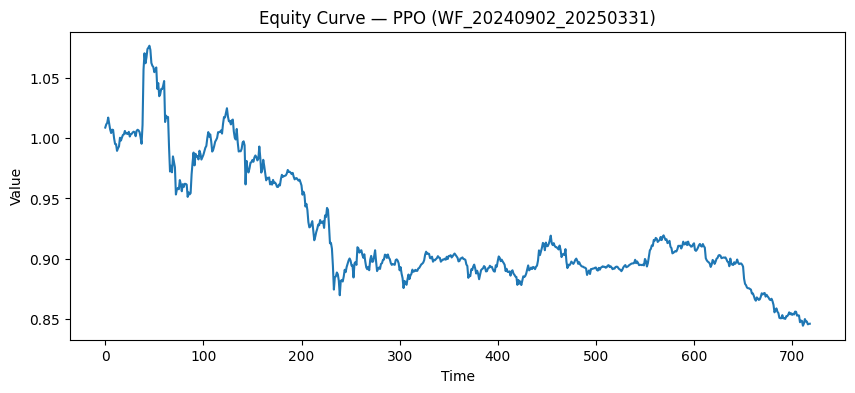

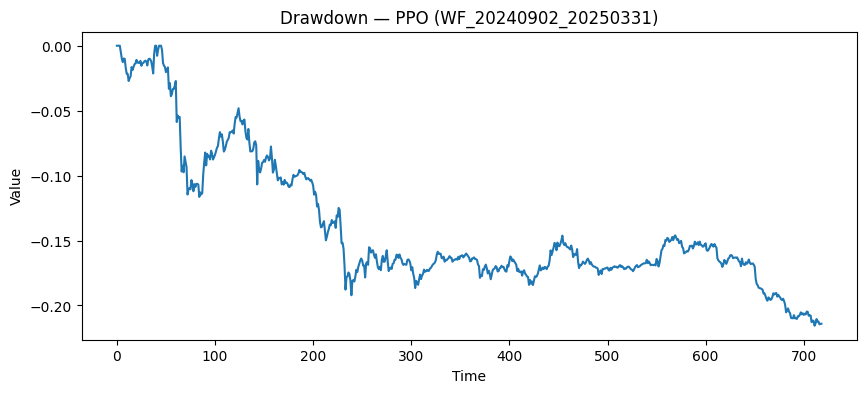

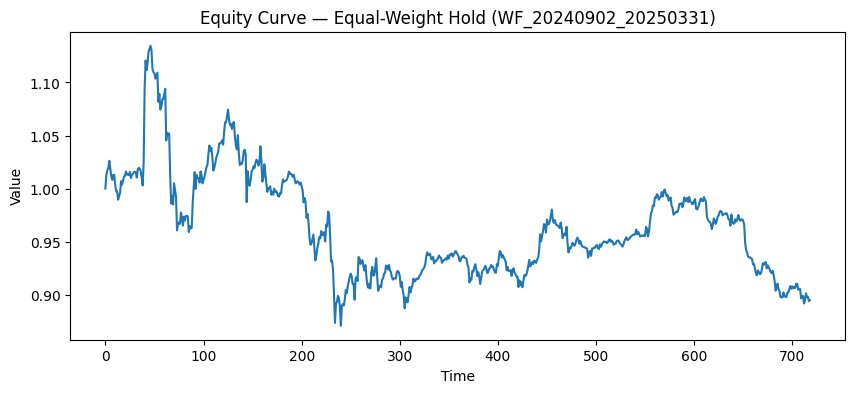


=== Training on split: WF_20241002_20250430 ===
Using mps device
Logging to ./tb/PPO_7
Eval num_timesteps=1000, episode_reward=0.04 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | 0.0447   |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
Eval num_timesteps=1000, episode_reward=0.04 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | 0.0447   |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 176  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 1024 |
-----------------------------
New best mean reward!
----------

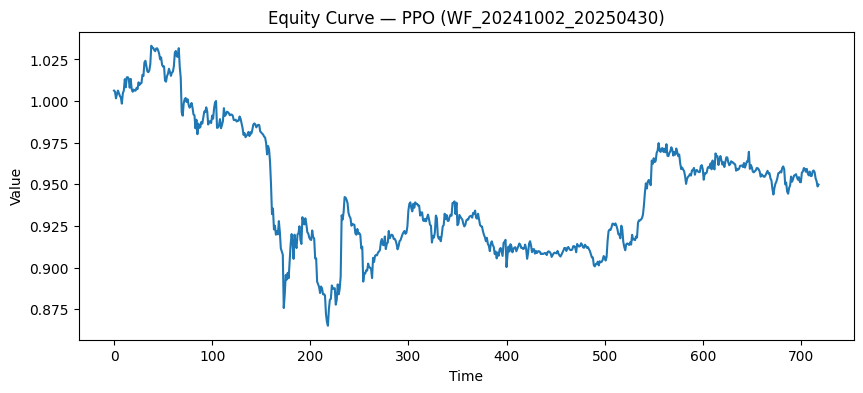

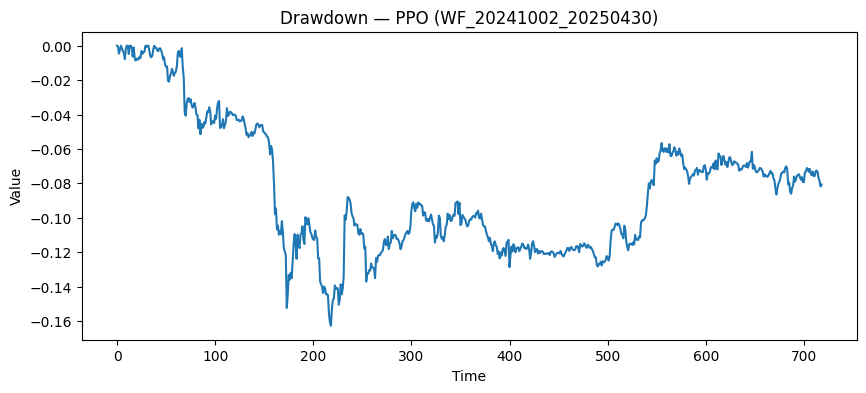

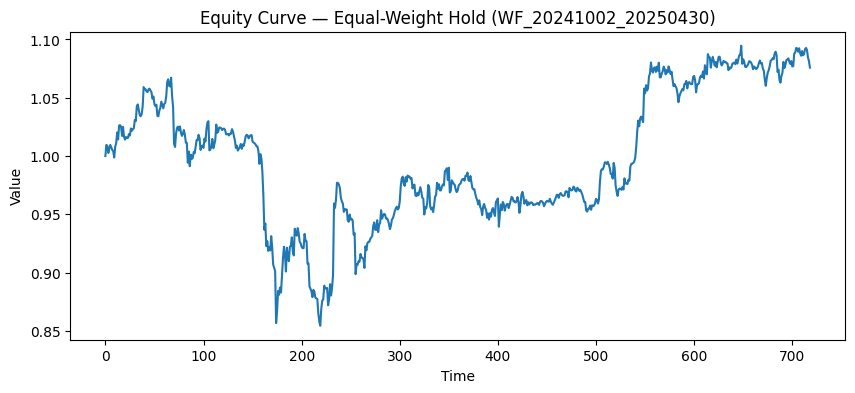


=== Training on split: WF_20241101_20250530 ===
Using mps device
Logging to ./tb/PPO_8
Eval num_timesteps=1000, episode_reward=0.16 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | 0.158    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
Eval num_timesteps=1000, episode_reward=0.16 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | 0.158    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 177  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 1024 |
-----------------------------
New best mean reward!
----------

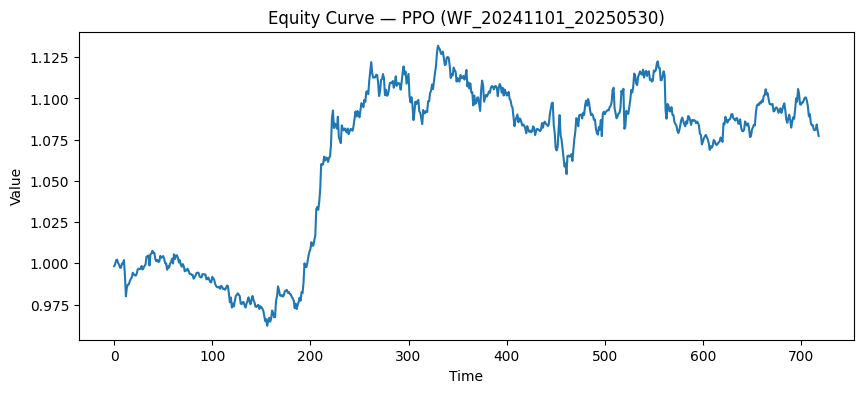

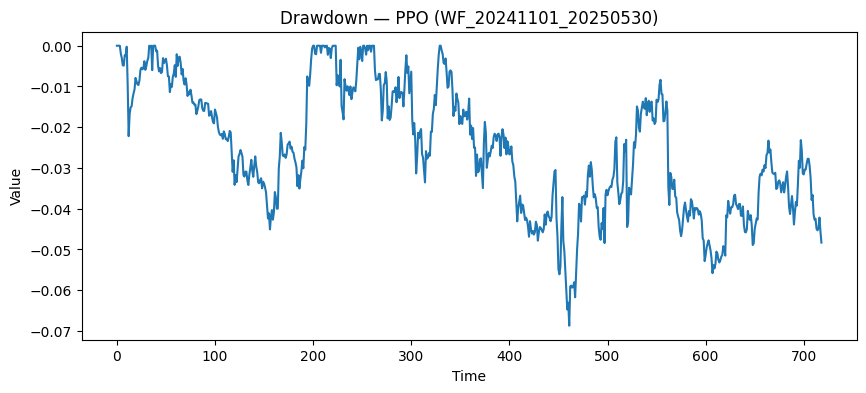

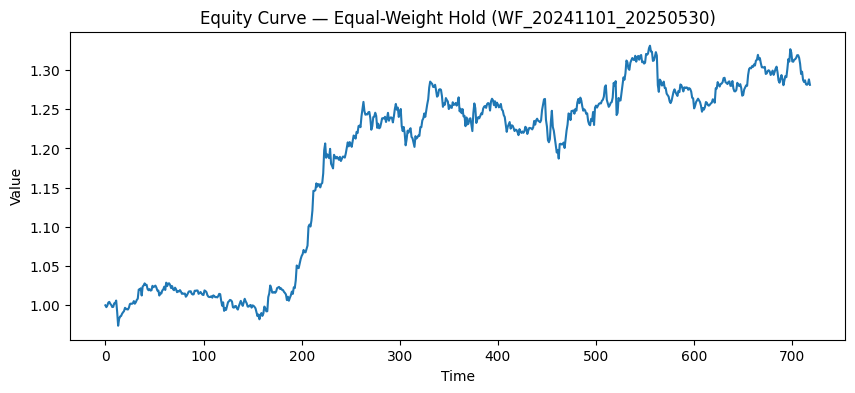


=== Training on split: WF_20241201_20250629 ===
Using mps device
Logging to ./tb/PPO_9
Eval num_timesteps=1000, episode_reward=-0.02 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | -0.0154  |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
Eval num_timesteps=1000, episode_reward=-0.02 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | -0.0154  |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 177  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 1024 |
-----------------------------
New best mean reward!
--------

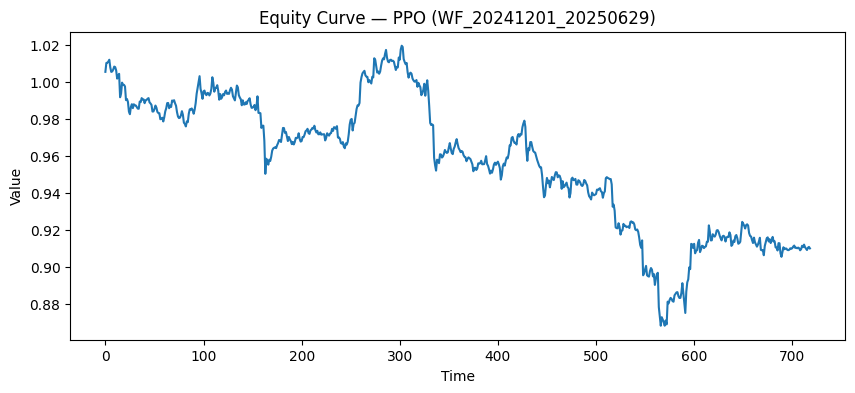

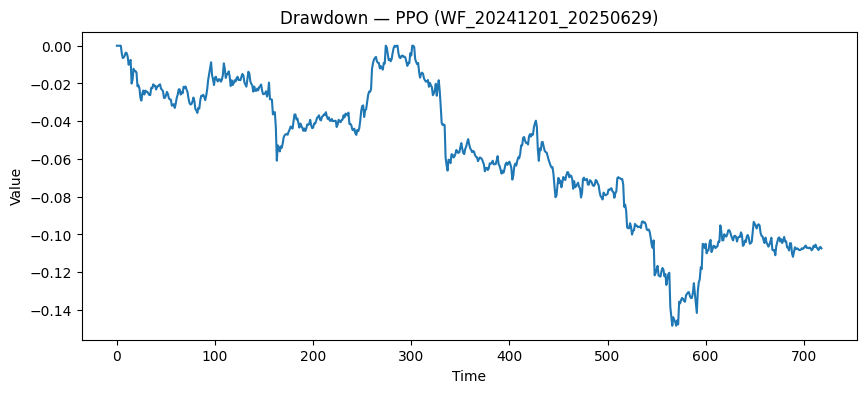

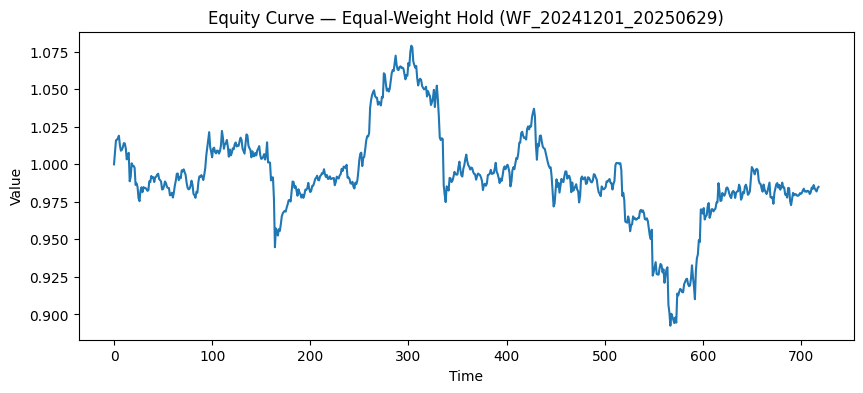


=== Training on split: WF_20241231_20250729 ===
Using mps device
Logging to ./tb/PPO_10
Eval num_timesteps=1000, episode_reward=0.17 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | 0.175    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
Eval num_timesteps=1000, episode_reward=0.17 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | 0.175    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 175  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 1024 |
-----------------------------
New best mean reward!
---------

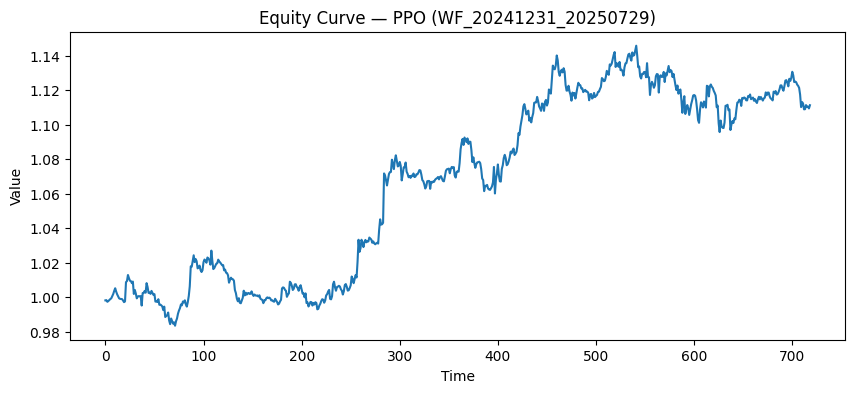

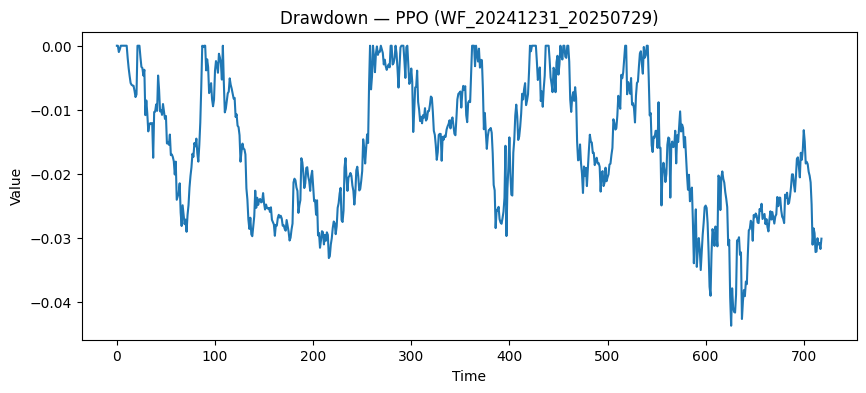

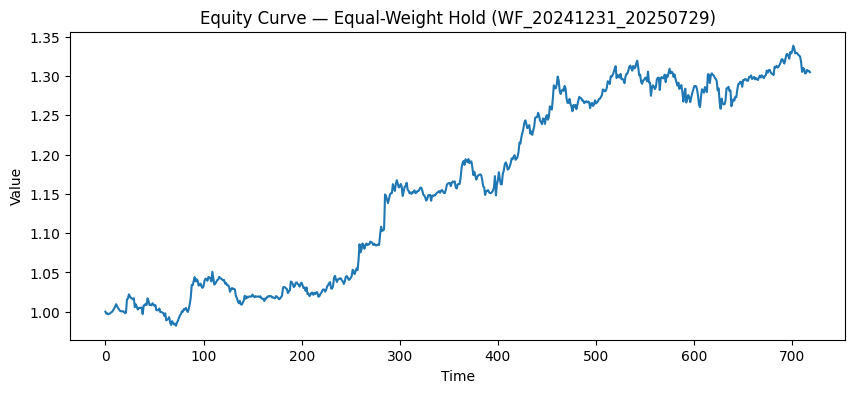


=== Training on split: WF_20250130_20250828 ===
Using mps device
Logging to ./tb/PPO_11
Eval num_timesteps=1000, episode_reward=0.03 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | 0.0346   |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
Eval num_timesteps=1000, episode_reward=0.03 +/- 0.00
Episode length: 719.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 719      |
|    mean_reward     | 0.0346   |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 178  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 1024 |
-----------------------------
New best mean reward!
---------

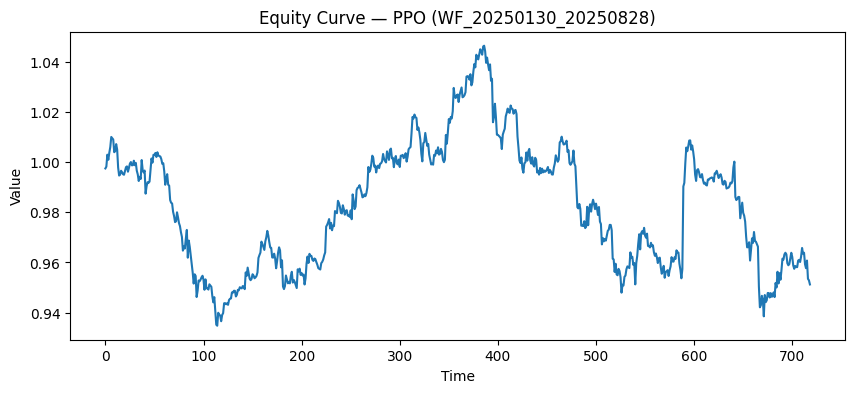

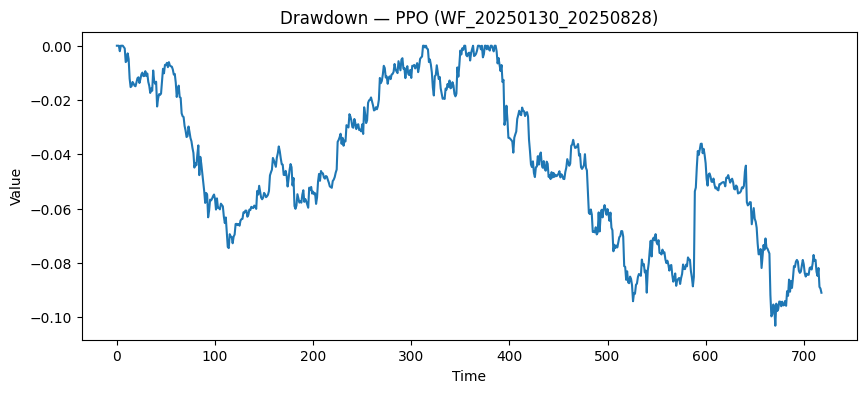

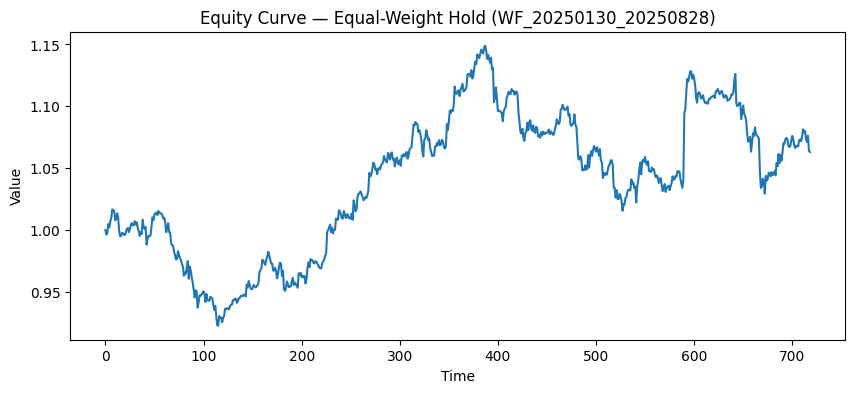

Done. RESULTS collected.


In [14]:
ensure_dir(CONFIG["IO"]["models_dir"])
ensure_dir(CONFIG["EVAL"]["reports_dir"])

RESULTS = []

for split in SPLITS:
    print(f"\n=== Training on split: {split['name']} ===")
    train_env = make_env_from_mask(split["train"], name=f"{split['name']}_train")
    eval_env  = make_env_from_mask(split["test"], name=f"{split['name']}_test")

    vec_train = DummyVecEnv([lambda: train_env])
    vec_eval  = DummyVecEnv([lambda: eval_env])

    model = PPO(
        policy=CONFIG["RL"]["policy"],
        env=vec_train,
        gamma=CONFIG["RL"]["gamma"],
        gae_lambda=CONFIG["RL"]["gae_lambda"],
        clip_range=CONFIG["RL"]["clip_range"],
        n_steps=CONFIG["RL"]["n_steps"],
        batch_size=CONFIG["RL"]["batch_size"],
        learning_rate=CONFIG["RL"]["learning_rate"],
        ent_coef=CONFIG["RL"]["ent_coef"],
        vf_coef=CONFIG["RL"]["vf_coef"],
        max_grad_norm=CONFIG["RL"]["max_grad_norm"],
        tensorboard_log=CONFIG["IO"]["tb_logdir"],
        device=CONFIG["RL"]["device"],
        verbose=1
    )

    eval_callback = EvalCallback(
        vec_eval, 
        best_model_save_path=CONFIG["IO"]["models_dir"],
        log_path=CONFIG["IO"]["models_dir"], 
        eval_freq=1000,  # Reduced from 10000 to 1000 for more frequent feedback
        deterministic=True, 
        render=False
    )
    
    model.learn(total_timesteps=CONFIG["RL"]["timesteps"], callback=eval_callback)
    model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{split['name']}.zip")
    model.save(model_path)
    print("Saved model:", model_path)

    test_env = make_env_from_mask(split["test"], name=f"{split['name']}_test")
    ec, to = backtest_env(test_env, model=model)

    idx = np.where(split["test"])[0]
    R_test = R_all[idx]
    ew = np.ones(len(TICKER_ORDER))/len(TICKER_ORDER)
    ec_bench = [1.0]
    # Only iterate through the same number of returns as we have in ec.index
    for i in range(len(ec.index)-1):
        ec_bench.append(ec_bench[-1]*math.exp(np.dot(ew, R_test[i])))
    ec_bench = pd.Series(ec_bench, index=ec.index)

    bh_btc, bh_eth = [1.0], [1.0]
    # Only iterate through the same number of returns as we have in ec.index
    for i in range(len(ec.index)-1):
        bh_btc.append(bh_btc[-1]*math.exp(R_test[i][0]))
        bh_eth.append(bh_eth[-1]*math.exp(R_test[i][1]))
    bh_btc = pd.Series(bh_btc, index=ec.index)
    bh_eth = pd.Series(bh_eth, index=ec.index)

    m_model = compute_metrics(ec, CONFIG["DATA"]["sampling"], to)
    m_ew    = compute_metrics(ec_bench, CONFIG["DATA"]["sampling"])
    m_btc   = compute_metrics(bh_btc, CONFIG["DATA"]["sampling"])
    m_eth   = compute_metrics(bh_eth, CONFIG["DATA"]["sampling"])

    RESULTS.append({"split": split["name"], "model": m_model, "equal_weight": m_ew, "buy_and_hold_BTC": m_btc, "buy_and_hold_ETH": m_eth})

    if CONFIG["EVAL"]["plots"]:
        plot_series(ec, f"Equity Curve — PPO ({split['name']})")
        plot_series((ec / ec.cummax()) - 1.0, f"Drawdown — PPO ({split['name']})")
        plot_series(ec_bench, f"Equity Curve — Equal-Weight Hold ({split['name']})")

print("Done. RESULTS collected.")

In [15]:

rows = []
for res in RESULTS:
    row = {"split": res["split"]}
    for k, metrics in res.items():
        if k == "split":
            continue
        for mname, mval in metrics.items():
            row[f"{k}_{mname}"] = mval
    rows.append(row)

df_results = pd.DataFrame(rows)
df_results


,split,model_CAGR,model_Sharpe,model_Sortino,model_MaxDrawdown,model_Calmar,model_Volatility,model_Turnover,model_HitRatio,equal_weight_CAGR,...,buy_and_hold_BTC_Turnover,buy_and_hold_BTC_HitRatio,buy_and_hold_ETH_CAGR,buy_and_hold_ETH_Sharpe,buy_and_hold_ETH_Sortino,buy_and_hold_ETH_MaxDrawdown,buy_and_hold_ETH_Calmar,buy_and_hold_ETH_Volatility,buy_and_hold_ETH_Turnover,buy_and_hold_ETH_HitRatio
0,WF_20240902_20250331,-0.882520,-4.326157,-5.121579,-0.215594,-9.433325,0.470109,0.121241,0.512535,-0.741688,...,NaN,0.509749,-0.917842,-2.576600,-3.177193,-0.292726,-7.359729,0.836134,NaN,0.516713
1,WF_20241002_20250430,-0.504834,-1.375785,-1.750080,-0.162714,-3.728570,0.440979,0.135401,0.484680,1.435667,...,NaN,0.491643,0.043611,0.475639,0.600360,-0.260495,1.556796,0.852615,NaN,0.504178
2,WF_20241101_20250530,1.527254,2.890354,3.990244,-0.068728,14.356398,0.341374,0.119000,0.504178,19.453231,...,NaN,0.505571,103.722489,6.596158,9.115442,-0.127122,38.851953,0.748758,NaN,0.523677
3,WF_20241201_20250629,-0.703087,-3.772760,-4.511105,-0.148355,-7.872710,0.309577,0.128568,0.490251,-0.168450,...,NaN,0.506964,-0.476860,-0.674098,-0.757892,-0.241518,-1.810187,0.648559,NaN,0.511142
4,WF_20241231_20250729,2.700321,4.650200,7.279822,-0.043703,30.947564,0.290845,0.115620,0.516713,24.610460,...,NaN,0.523677,212.339637,9.085431,14.988353,-0.077084,72.101976,0.611736,NaN,0.534819
5,WF_20250130_20250828,-0.439258,-1.600243,-2.295147,-0.103114,-5.096630,0.328408,0.112068,0.484680,1.105871,...,NaN,0.491643,7.913648,3.428473,5.325247,-0.146379,16.688259,0.712505,NaN,0.509749


In [16]:

from datetime import datetime
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ensure_dir(CONFIG["EVAL"]["reports_dir"])
out_json = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.json")
out_csv  = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.csv")
df_results.to_csv(out_csv, index=False)
with open(out_json, "w") as f:
    json.dump(RESULTS, f, indent=2)
print("Saved:", out_json, "and", out_csv)


Saved: ./reports/metrics_20250907_205218.json and ./reports/metrics_20250907_205218.csv
